Лабораторная работа №8. 
Рекуррентные нейронные сети для анализа временных рядов
Данные: Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017. Данные в виде csv-файла можно скачать на сайте Kaggle -> https://www.kaggle.com/robervalt/sunspots/

Задание 1.
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [103]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/8_lab/Sunspots.csv', index_col='Date', parse_dates=['Date'])
df.head()

Unnamed: 0  Monthly Mean Total Sunspot Number
Date                                                     
1749-01-31           0                               96.7
1749-02-28           1                              104.3
1749-03-31           2                              116.7
1749-04-30           3                               92.8
1749-05-31           4                              141.7

In [104]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df

Monthly Mean Total Sunspot Number
Date                                         
1749-01-31                               96.7
1749-02-28                              104.3
1749-03-31                              116.7
1749-04-30                               92.8
1749-05-31                              141.7
...                                       ...
2019-08-31                                0.5
2019-09-30                                1.1
2019-10-31                                0.4
2019-11-30                                0.5
2019-12-31                                1.6

[3252 rows x 1 columns]

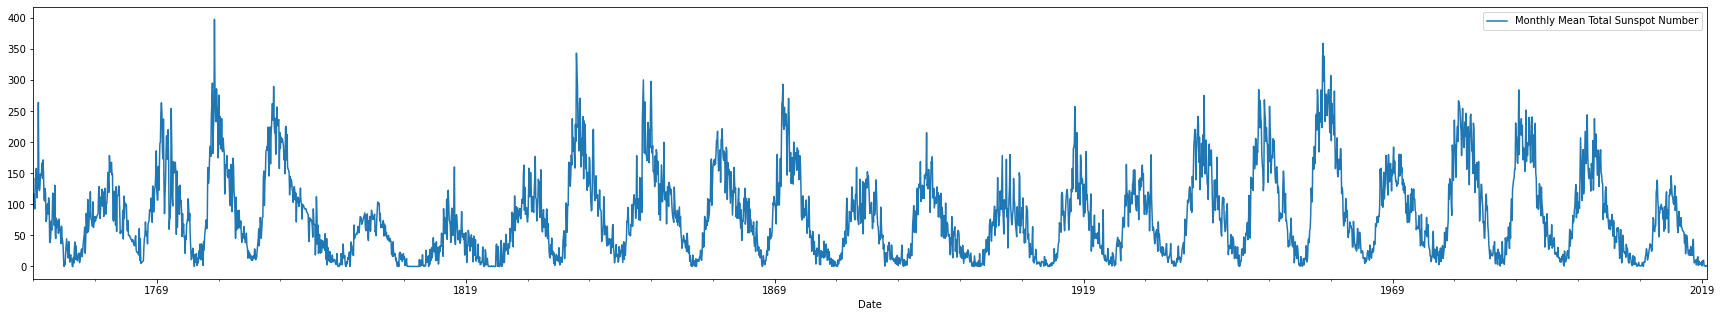

In [105]:
import matplotlib.pyplot as plt

df.plot(figsize=(30,5))
plt.show()

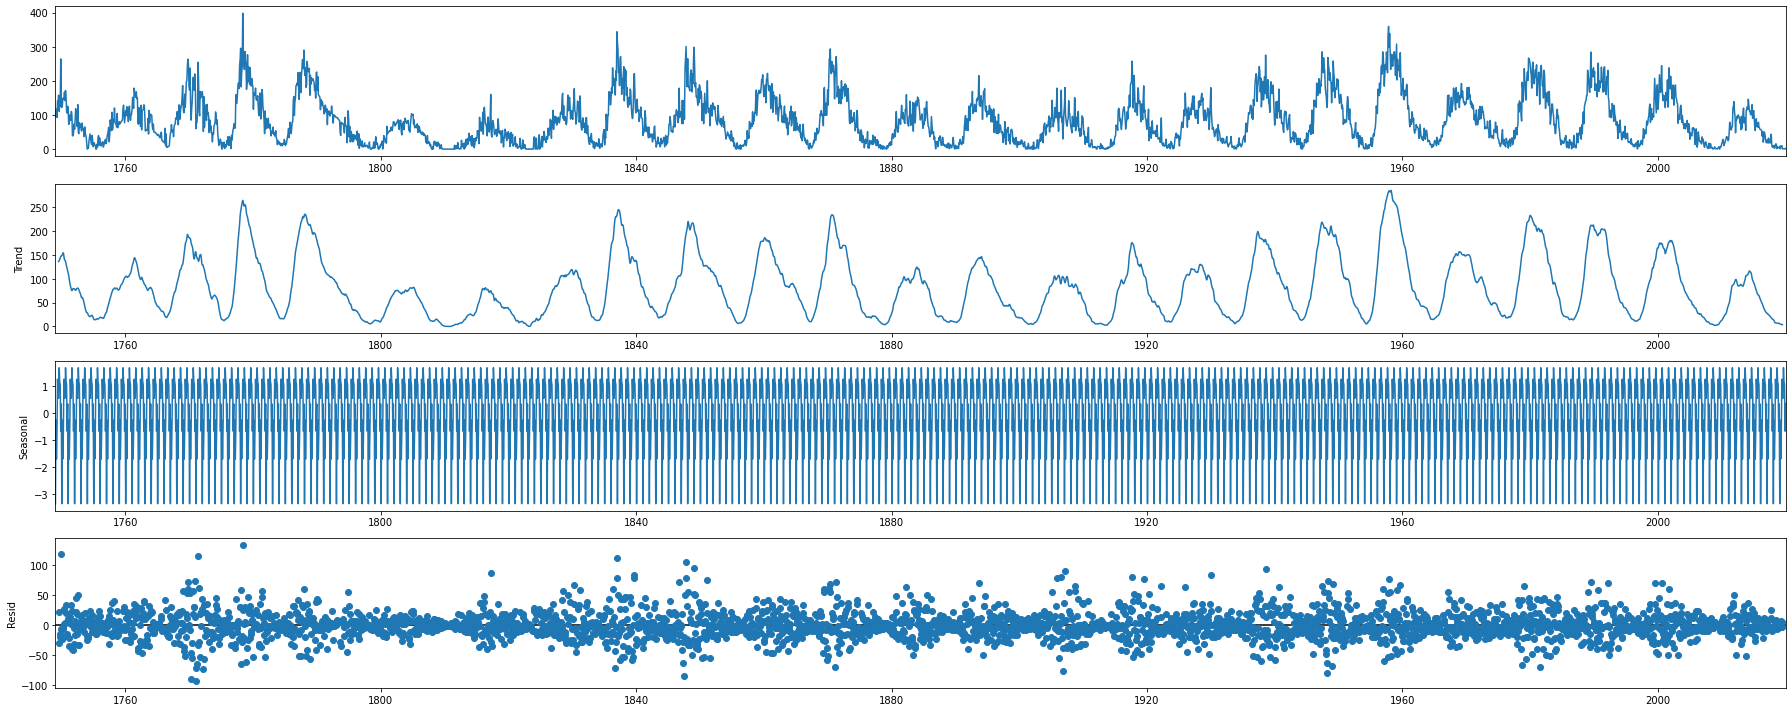

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 25, 10
decomposition = seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

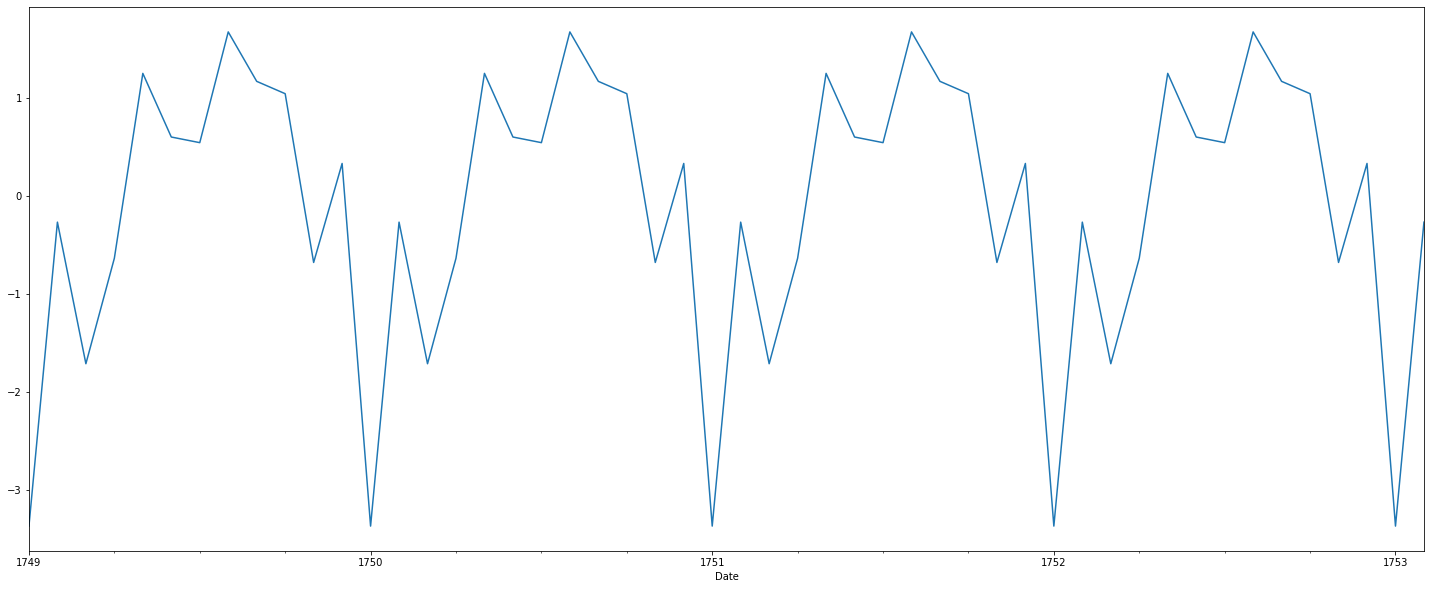

In [107]:
decomposition.seasonal[:50].plot()
plt.show()

There is a seasonality in the series. One season - 1 year. It means that the series is non-stationary. 

There is no trend.

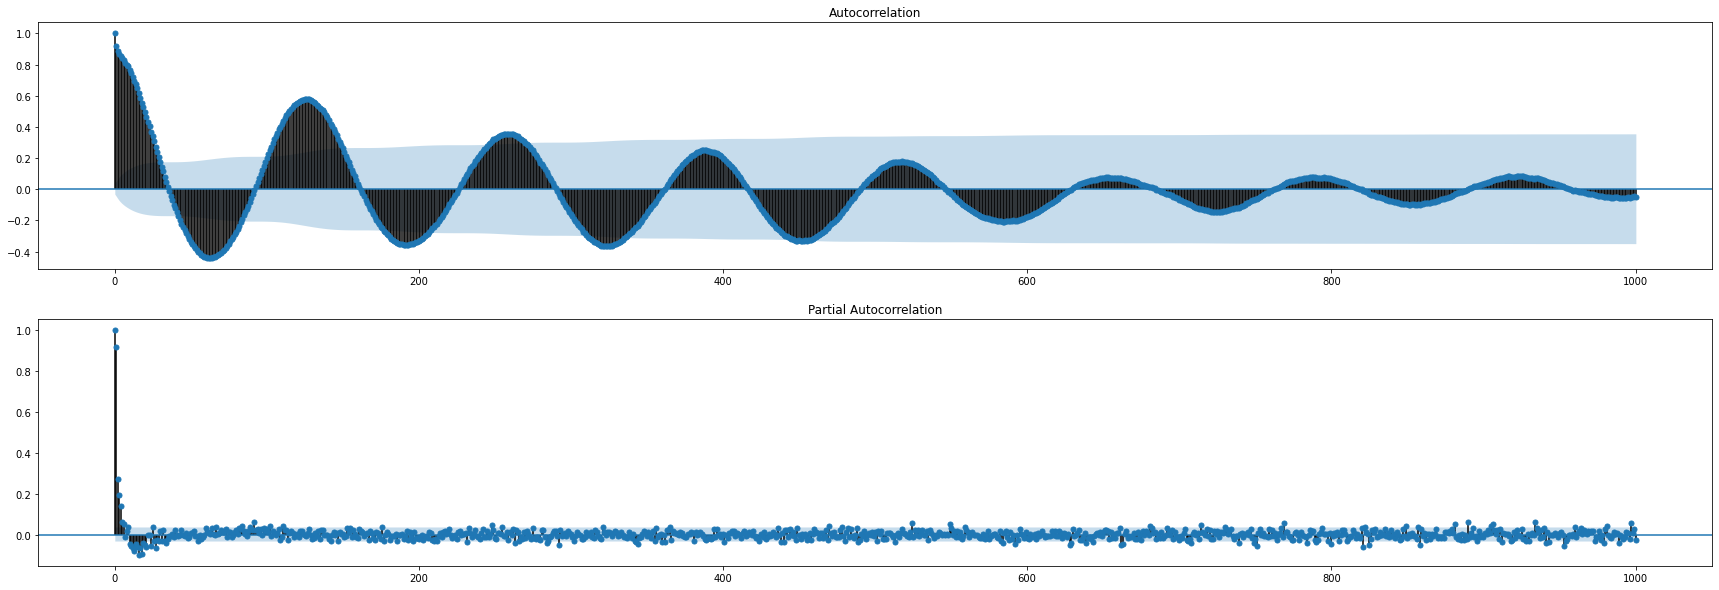

In [110]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))
plot_acf(df, lags=1000, ax=ax1)
plot_pacf(df, lags=1000, ax=ax2)
plt.show()

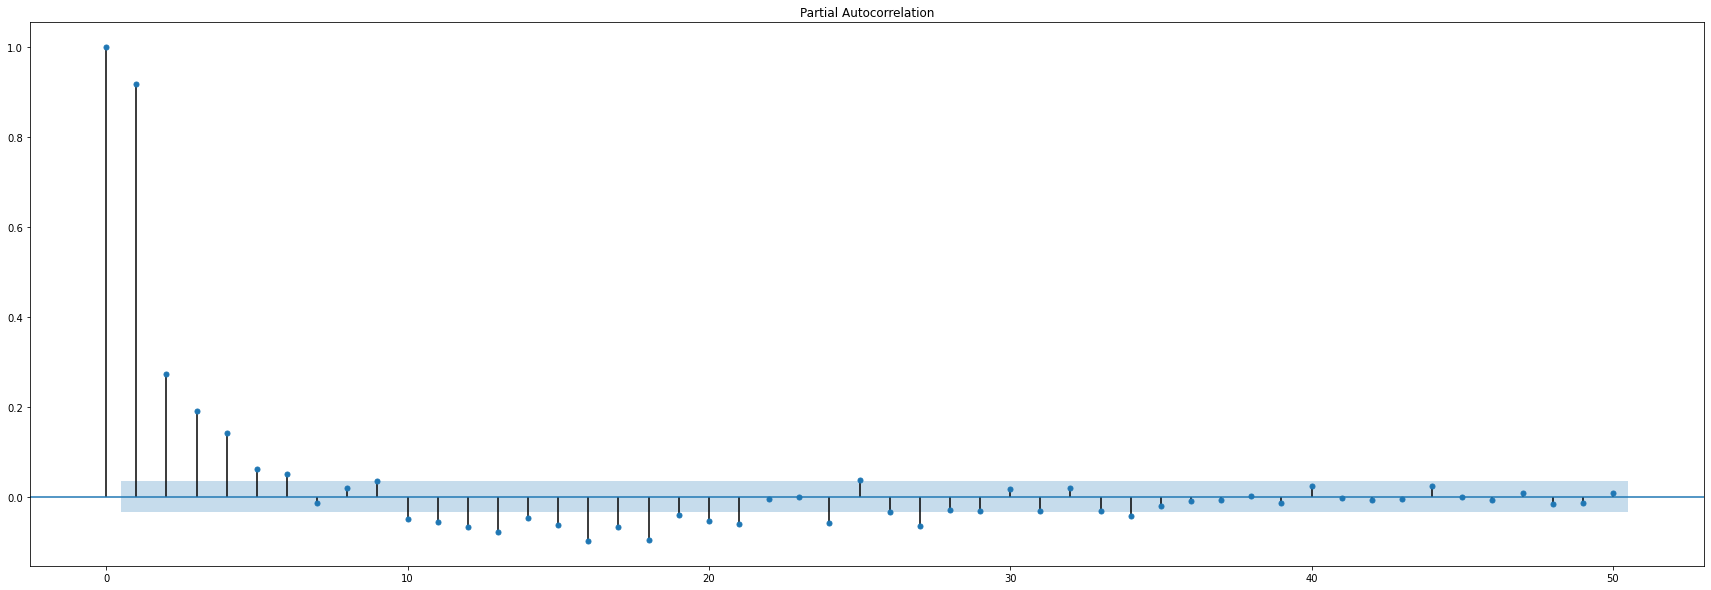

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plot_pacf(df, lags=50, ax=ax)
plt.show()

Задание 2.
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.

In [112]:
len(df)

3252

In [0]:
df_train = df[:-800]
df_val = df[-800:-400]
df_test = df[-400:]

Задание 3.
Примените модель ARIMA для прогнозирования значений данного временного ряда.

In [0]:
!pip install pmdarima

In [274]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(
    df, 
    n_jobs=-1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False, 
    random=True,
    n_fits=100)

Total fit time: 33.480 seconds


In [275]:
arima_model.aic()

30082.487195623213

In [276]:
arima_model.fit(df_train.append(df_val))

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
long_forecast = arima_model.predict(n_periods=len(df_test))
forecast = []
for v in df_test.values:
    forecast.append(arima_model.predict(n_periods=1))
    arima_model.update(v)

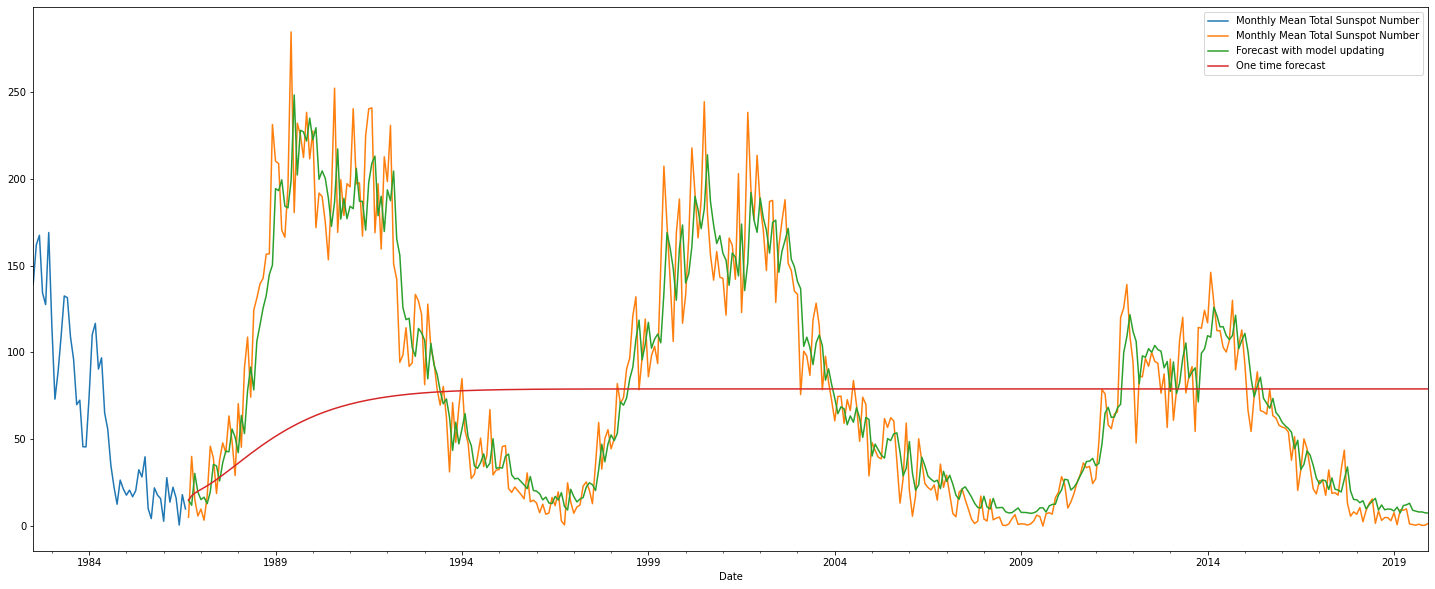

In [278]:
df_long_forecast = pd.DataFrame(long_forecast, index = df_test.index, columns=['One time forecast'])
df_forecast = pd.DataFrame(forecast, index = df_test.index, columns=['Forecast with model updating'])

pd.concat([df_train_val[-50:], df_test, df_forecast, df_long_forecast], axis=1).plot()
plt.show()

Задание 4.
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

In [280]:
values = df['Monthly Mean Total Sunspot Number']
mean = values.mean()
std = values.std()
normalized_series = (values - mean) / std
normalized_series

Date
1749-01-31    0.215566
1749-02-28    0.327553
1749-03-31    0.510270
1749-04-30    0.158098
1749-05-31    0.878649
                ...   
2019-08-31   -1.201960
2019-09-30   -1.193119
2019-10-31   -1.203433
2019-11-30   -1.201960
2019-12-31   -1.185751
Name: Monthly Mean Total Sunspot Number, Length: 3252, dtype: float64

In [281]:
import numpy as np

WINDOW_SIZE = 12

X, y = [], []
values = normalized_series.values
for i in range(len(values) - WINDOW_SIZE):
  X.append(values[i : i + WINDOW_SIZE])
  y.append(values[i + WINDOW_SIZE])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (*X.shape, 1))
print(X.shape, y.shape)

(3240, 12, 1) (3240,)


In [0]:
X_train, y_train, X_test, y_test = X[:-400], y[:-400], X[-400:], y[-400:]

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(fit_hist):
    epoch_count = len(fit_hist.history['loss'])
    _, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(fit_hist.history['loss'])
    ax.plot(fit_hist.history['val_loss'])
    ax.set_title('Loss')
    ax.legend(['train', 'val'])
    plt.show()

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

def get_model():
    model = Sequential()
    model.add(GRU(12, input_shape=(12,1), return_sequences=True))
    model.add(GRU(12, return_sequences=True))
    model.add(GRU(12))
    model.add(Dense(1))
    
    return model

In [285]:
get_model().summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_79 (GRU)                 (None, 12, 12)            540       
_________________________________________________________________
gru_80 (GRU)                 (None, 12, 12)            936       
_________________________________________________________________
gru_81 (GRU)                 (None, 12)                936       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 13        
Total params: 2,425
Trainable params: 2,425
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
71/71 [==============================] - 2s 27ms/step - loss: 0.4219 - val_loss: 0.4012
Epoch 2/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2994 - val_loss: 0.3772
Epoch 3/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2883 - val_loss: 0.3388
Epoch 4/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2794 - val_loss: 0.3253
Epoch 5/10
71/71 [==============================] - 1s 12ms/step - loss: 0.2752 - val_loss: 0.3137
Epoch 6/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2731 - val_loss: 0.3137
Epoch 7/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2711 - val_loss: 0.3028
Epoch 8/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2687 - val_loss: 0.3041
Epoch 9/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2666 - val_loss: 0.2967
Epoch 10/10
71/71 [==============================] - 1s 13ms/step - loss: 0.2669 - val_loss: 0.3003


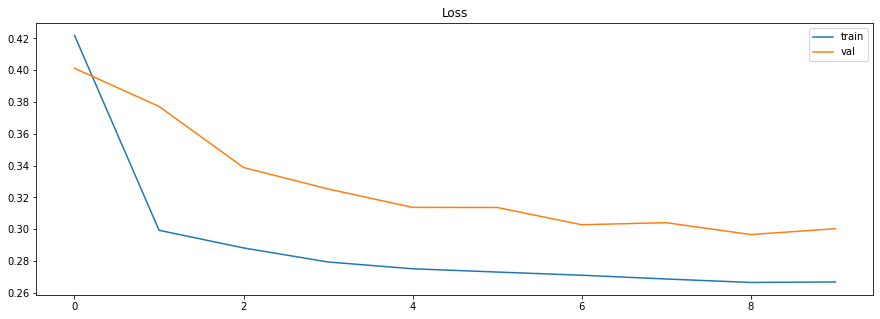

13/13 [==============================] - 0s 5ms/step - loss: 0.2367


0.2367435097694397

In [286]:
model = get_model()
model.compile(optimizer='adam', loss='mae')

history = model.fit(
    X_train, 
    y_train, 
    epochs=,
    validation_split=0.2)
plot_accuracy_and_loss(history)

model.evaluate(X_test, y_test, verbose=1)

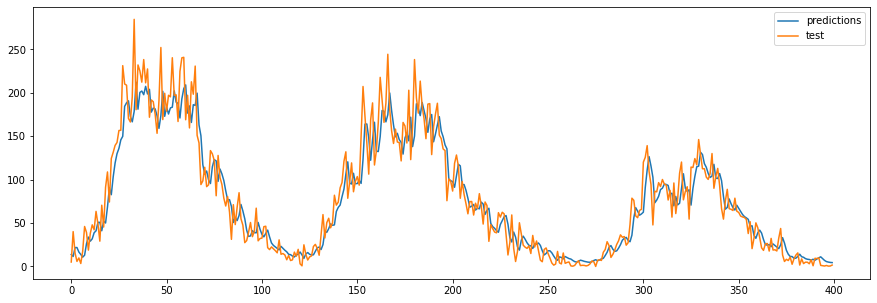

In [287]:
preds = mean + model.predict(X_test) * std
plt.figure(figsize=(15, 5))
plt.plot(preds, label="predictions")
plt.plot(df_test.values, label="test")
plt.legend()
plt.show()

Задание 5.
Сравните качество прогноза моделей.
Какой максимальный результат удалось получить на контрольной выборке?

In [288]:
from sklearn.metrics import mean_absolute_error

print(f'RNN MAE Error: {mean_absolute_error(df_test, preds)}')
print(f'ARIMA MAE Error: {mean_absolute_error(df_test, forecast)}')

RNN MAE Error: 16.06653753662109
ARIMA MAE Error: 15.71819384020704
